<a href="https://colab.research.google.com/github/Sawaiz8/Keras-Practice-Modeling/blob/Transfer-Learning-in-Keras/Heaton_CV_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
#Loading data:Load data as keras dataset to not blow your RAM
import tensorflow_datasets as tfds
import tensorflow as tf

#BY default the batch_size is 32
#B size the number of examples sent to model before weights are updated or prediction are made.
#Important in Colab if you dont want to run out of RAM

train_ds, validation_ds, test_ds = tfds.load(
    'cats_vs_dogs',
    split = ['train[:60%]', 'train[60%:80%]', 'train[80%:100%]'],
    as_supervised = True
)

num_train = tf.data.experimental.cardinality(train_ds)
num_validation = tf.data.experimental.cardinality(validation_ds)
num_test = tf.data.experimental.cardinality(test_ds)

print('Number of training samples:', num_train)
print('Number of validation samples:', num_validation)
print('Number of test samples:', num_test)

Number of training samples: tf.Tensor(13957, shape=(), dtype=int64)
Number of validation samples: tf.Tensor(4653, shape=(), dtype=int64)
Number of test samples: tf.Tensor(4652, shape=(), dtype=int64)


In [37]:
#Resizing image using lambda functions.

size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x,size),y))

In [3]:
#tensorflow input pipeline
#If you have many images, then you cannot everything into RAM. 
#Sol 1: Load it into batches in the RAM. 
#tf.data.dataset --> it is the data type used to store Data in RAM. 


#tf.dataset.filter(filter_func) --> filter outs data
#tf.dataset.map(lambda <function>) --> map outs data transformation to each example


In [4]:
#ETL was made of three buckets
#Extract: Get data from different sources: file system, in memory arrays, distributed file system like S3 browser
#Transform: data augmnetation and coverting to tensors
#Load the data: into GPU or TPU

#Standard pipeline ETL like databases
#extract using API

#transform --> batch load, shuffle, fileter or map
#dataset = dataset.shuffle(10000)
#dataset = dataset.repeat(NUM_EPOCHS)
#dataset = dataset.map(lambda x: tf.parse_single_example(x,features))
#dataset = dataset.batch(BATCH_SIZE)

#benefits of tf.data: you can stream data directly from distrbuted structure like S3. 

#load
#iterator = dataset.make_one_shot_iterator()
#features = iterator.get_next()


#Prefetching importance
#Prefetching overlaps the preprocessing and model execution of a training step. 
#While the model is executing training step s, the input pipeline is reading 
#the data for step s+1. Doing so reduces the step time to the 
#maximum (as opposed to the sum) of the training and the time it takes to extract the data.
#Note: The number of elements to prefetch should be equal 
#to (or possibly greater than) the number of batches consumed by a single training step

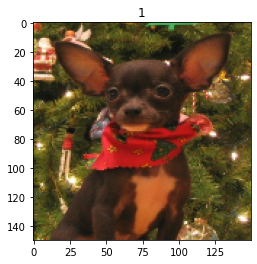

In [5]:
#take() brings some examples out
import matplotlib.pyplot as plt
for image,label in train_ds.take(2):
  image = image/255
  plt.imshow(image)
  plt.title(int(label))

In [38]:
#cahching and prefetching increase the speed of the performance.
train_ds = train_ds.cache().batch(32).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(32).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(32).prefetch(buffer_size=10)

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

#You can augment the data in layers
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

#Note: preprocessing and augmentation is different
#You can edit the current images or augment and create new ones

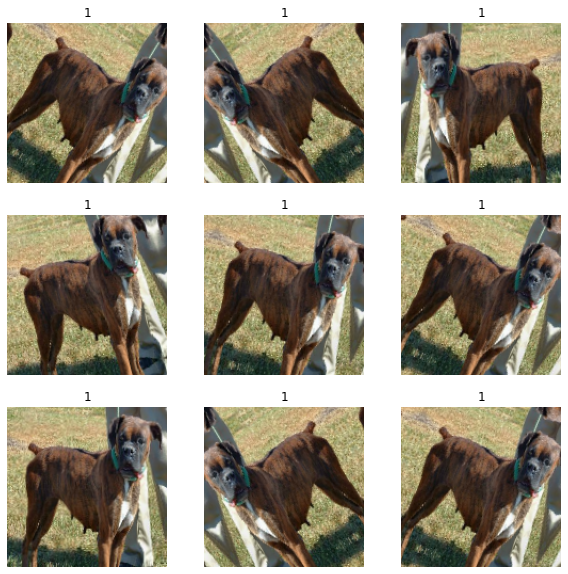

In [8]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [9]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.
base_model.trainable = False

base_model.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 74, 74, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                          

In [10]:
inputs = keras.Input(shape = (150,150,3)) #Input layer can be made like this
x  = data_augmentation(inputs) #augment the images

#add the preprocess data layer 
#We scale from -1 to 1 since neural nets like that better. Why?
#WHy offset? inputs * scale + 1
scale_layer = keras.layers.Rescaling(scale = 1/127.5, offset = -1)
x = scale_layer(x)

#We want to keep the batch normalization layers in inference mode (testing mode).
#Inference is where to use the model for prediction and since we only have one example to test
#we use the previous mean and s.d calculated during training. (For 1 batch or whole?)
x = base_model(x, training = False)
#GlobalAveragePooling is used often instead of flatten. Why?
x = keras.layers.GlobalAveragePooling2D()(x) 
#Dropout to reduce overfitting
x = keras.layers.Dropout(0.2)(x)

layersAndOutputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, layersAndOutputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [11]:
model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.BinaryCrossentropy(from_logits = True),
    metrics = [keras.metrics.BinaryAccuracy()]
)

epochs = 10
model.fit(train_ds, epochs = epochs, validation_data = validation_ds)

Epoch 1/10
437/437 [==============================] - 60s 111ms/step - loss: 0.1534 - binary_accuracy: 0.9342 - val_loss: 0.0781 - val_binary_accuracy: 0.9710
Epoch 2/10
437/437 [==============================] - 40s 92ms/step - loss: 0.1159 - binary_accuracy: 0.9502 - val_loss: 0.0752 - val_binary_accuracy: 0.9729
Epoch 3/10
437/437 [==============================] - 41s 93ms/step - loss: 0.1071 - binary_accuracy: 0.9567 - val_loss: 0.0753 - val_binary_accuracy: 0.9731
Epoch 4/10
437/437 [==============================] - 41s 95ms/step - loss: 0.1042 - binary_accuracy: 0.9587 - val_loss: 0.0729 - val_binary_accuracy: 0.9734
Epoch 5/10
437/437 [==============================] - 43s 98ms/step - loss: 0.1057 - binary_accuracy: 0.9570 - val_loss: 0.0767 - val_binary_accuracy: 0.9740
Epoch 6/10
437/437 [==============================] - 42s 95ms/step - loss: 0.1032 - binary_accuracy: 0.9592 - val_loss: 0.0724 - val_binary_accuracy: 0.9744
Epoch 7/10
437/437 [==============================]

In [18]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
pred = model.predict(test_ds)


146/146 [==============================] - 8s 58ms/step


In [39]:
y = np.concatenate([y for x, y in test_ds], axis=0)

In [46]:
logits = tf.sigmoid(pred)

In [30]:
pred.size

4652

In [53]:
import numpy as np
np.max(logits)

0.9999975

In [54]:
logits2 = np.where(logits >= 0.5, 1, 0)

In [58]:
score = np.sqrt(metrics.mean_squared_error(logits2,y))
print(f"Final score (RMSE): {score}")

Final score (RMSE): 0.15023627135714718
